### 1) Initial Imports and loading the utils function. The dataset is used is <a href='https://www.kaggle.com/adityajn105/flickr8k'>Flickr 8k</a> from kaggle.Custom dataset and dataloader is implemented in <a href='https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k'> this</a> notebook.


In [1]:
#imports 
import os
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from PIL import Image

class Vocabulary:
    #tokenizer
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
        
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        
        #staring index 4
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    
    
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets


def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):
    """
    Returns torch dataloader for the flicker8k dataset
    
    Parameters
    -----------
    dataset: FlickrDataset
        custom torchdataset named FlickrDataset 
    batch_size: int
        number of data to load in a particular batch
    shuffle: boolean,optional;
        should shuffle the datasests (default is False)
    num_workers: int,optional
        numbers of workers to run (default is 1)  
    """

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return data_loader

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

#custom imports 
# from data_loader import FlickrDataset,get_data_loader


### 2) Implementing the Helper function to plot the Tensor image

In [3]:
#for image plot
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
#setting the constants
data_location =  "../input/flickr8k"
BATCH_SIZE = 256
NUM_WORKER = 8

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(256),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

caption_file = os.path.join(data_location, 'captions.txt')

#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    caption_file = caption_file,
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
)

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

### 3) Defining the Model Architecture
#### Model is seq2seq model. In the encoder pretrained ResNet model is used to extract the features. Decoder, takes the encoder context as first input and generates the caption. In the decoder model LSTM cell.

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions[:,:-1])
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]
        
            
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 4) Setting Hypperparameter and Init the model

In [8]:
# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

In [9]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


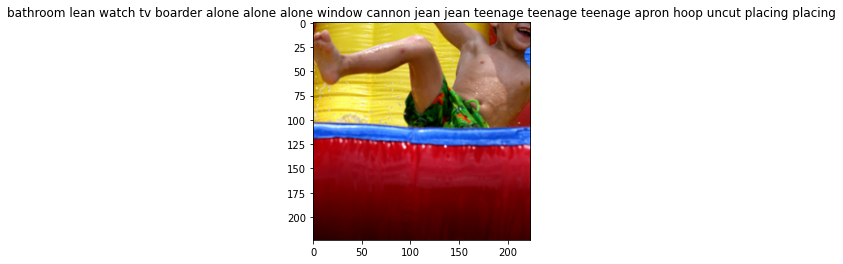

In [10]:
dataiter = iter(data_loader)
img,_ = next(dataiter)
features = model.encoder(img[0:1].to(device))
caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
caption = ' '.join(caps)
show_image(img[0],title=caption)

In [11]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'no_attention_model_state.pth')

### 5) Training Job from above configs

Epoch: 1 loss: 4.56190


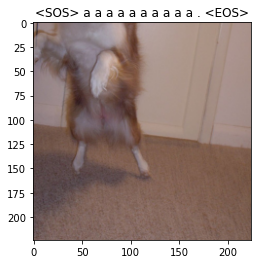

Epoch: 2 loss: 4.16754


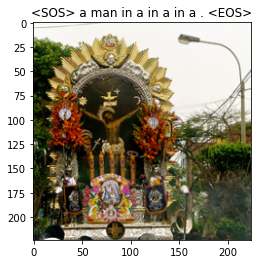

Epoch: 3 loss: 3.79686


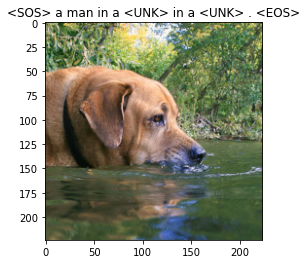

Epoch: 4 loss: 3.59309


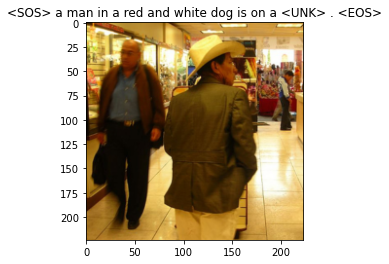

Epoch: 5 loss: 3.36519


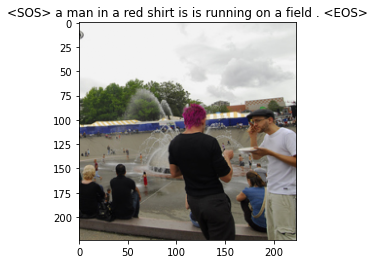

Epoch: 6 loss: 3.22622


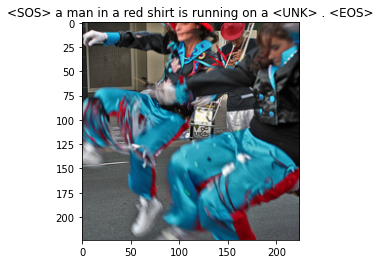

Epoch: 7 loss: 3.12701


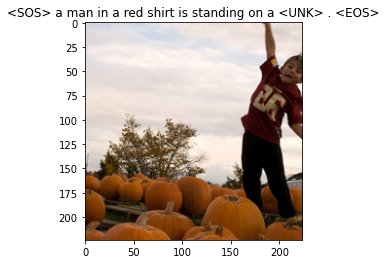

Epoch: 8 loss: 3.11087


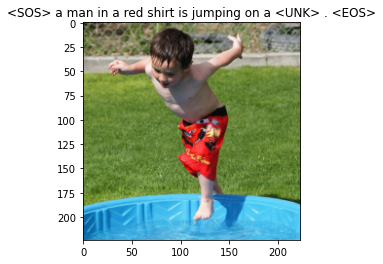

Epoch: 9 loss: 2.94259


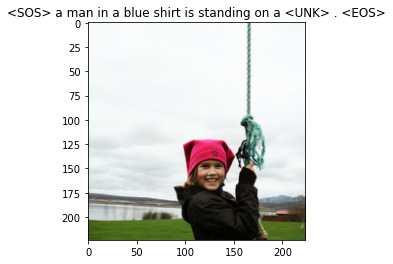

Epoch: 10 loss: 3.00584


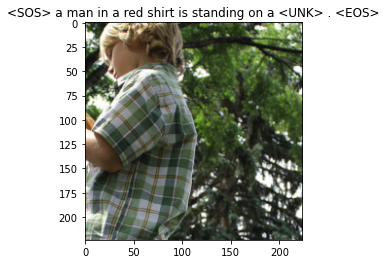

Epoch: 11 loss: 2.90514


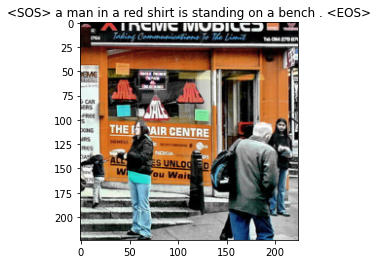

Epoch: 12 loss: 2.82576


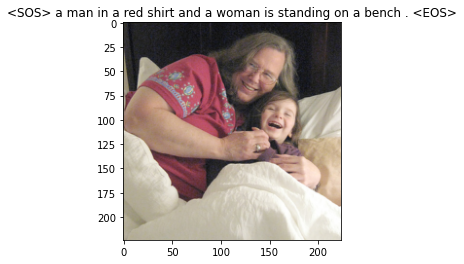

Epoch: 13 loss: 2.78688


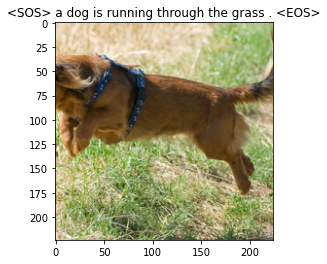

Epoch: 14 loss: 2.72640


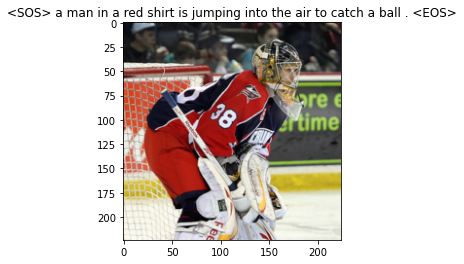

Epoch: 15 loss: 2.74502


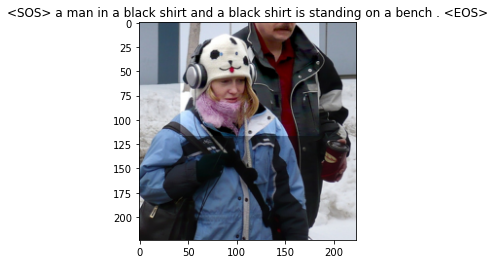

Epoch: 16 loss: 2.69636


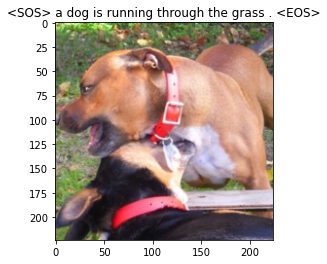

Epoch: 17 loss: 2.61190


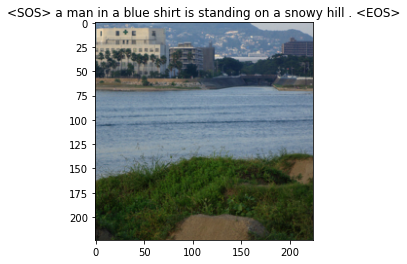

Epoch: 18 loss: 2.62632


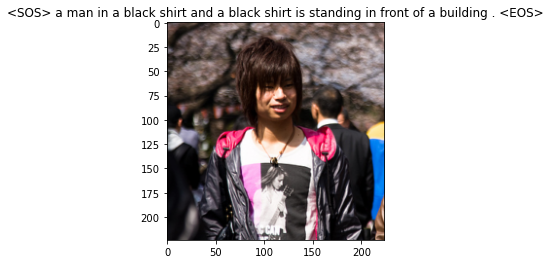

Epoch: 19 loss: 2.58532


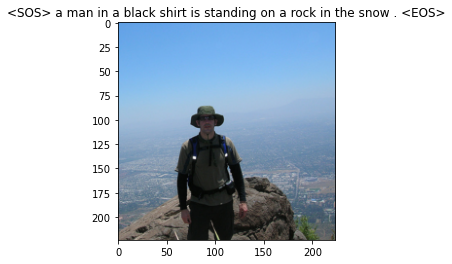

Epoch: 20 loss: 2.48265


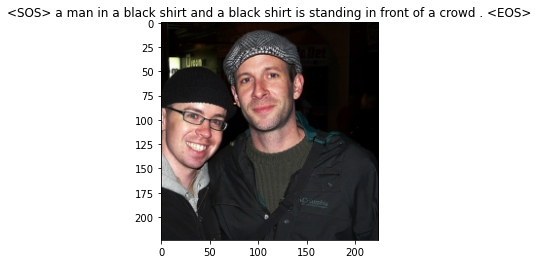

In [12]:
num_epochs = 20
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()

    save_model(model,epoch)

save_model(model,'no_attention_model_FULL.pth')